In [1]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torch
import torch.optim as optim
from torch.autograd import Variable

from typing import Callable

2024-03-28 11:18:27.435514: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-28 11:18:27.557070: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 11:18:27.557178: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 11:18:27.559807: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-28 11:18:27.575426: I tensorflow/core/platform/cpu_feature_guar

In [2]:
"""
Here we load the dataset, add gaussian,poisson,speckle

    'gauss'     Gaussian-distributed additive noise.
    'speckle'   Multiplicative noise using out = image + n*image,where
                n is uniform noise with specified mean & variance.
                
We define a function that adds each noise when called from main function
Input & Output: np array
                
"""


def add_noise(img, noise_type="gaussian"):
  
  row, col = 28, 28
  img = img.astype(np.float32)
  
  if noise_type == "gaussian":
    mean  = 0
    var   = 10
    sigma = var**.5
    noise = np.random.normal(-5.9, 5.9, img.shape)
    noise = noise.reshape(row, col)
    img   = img + noise
    return img

  if noise_type == "speckle":
    noise = np.random.randn(row, col)
    noise = noise.reshape(row, col)
    img   = img + img*noise
    return img

In [3]:
#Here we load the dataset from keras
(xtrain, ytrain), (xtest, ytest) = mnist.load_data()
print("No of training datapoints:{}\nNo of Test datapoints:{}".format(len(xtrain), len(xtest)))

No of training datapoints:60000
No of Test datapoints:10000


In [4]:
"""
From here onwards,we split the 60k training datapoints into 3 sets each given one type of each noise.
We shuffle them for better generalization.
"""
noises = ["gaussian", "speckle"]
noise_ct = 0
noise_id = 0
traindata = np.zeros((60000, 28, 28))



for idx in tqdm(range(len(xtrain))):
  if noise_ct < len(xtrain)/2:
    noise_ct += 1
    traindata[idx] = add_noise(xtrain[idx], noise_type=noises[noise_id])
  else:
    print("\n{} noise addition completed to images".format(noises[noise_id]))
    noise_id += 1
    noise_ct = 0


print("\n{} noise addition completed to images".format(noises[noise_id])) 


noise_ct = 0
noise_id = 0
testdata = np.zeros((10000, 28, 28))

for idx in tqdm(range(len(xtest))):
  if noise_ct < len(xtest)/2:
    noise_ct += 1
    x = add_noise(xtest[idx], noise_type=noises[noise_id])
    testdata[idx] = x
    
  else:
    print("\n{} noise addition completed to images".format(noises[noise_id]))
    noise_id += 1
    noise_ct = 0

print("\n{} noise addition completed to images".format(noises[noise_id]))    
  

 55%|█████▍    | 32985/60000 [00:02<00:01, 15874.92it/s]


gaussian noise addition completed to images


100%|██████████| 60000/60000 [00:03<00:00, 15311.62it/s]



speckle noise addition completed to images


 75%|███████▍  | 7472/10000 [00:00<00:00, 14763.84it/s]


gaussian noise addition completed to images


100%|██████████| 10000/10000 [00:00<00:00, 14707.53it/s]


speckle noise addition completed to images


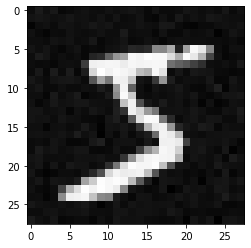

In [5]:
plt.imshow(traindata[0], cmap="gray")

Text(0.5, 1.0, 'Noised Image')

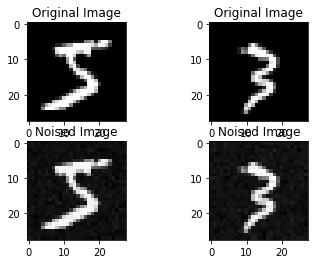

In [6]:
"""
Here we Try to visualize, each type of noise that was introduced in the images
Along with their original versions

"""

f, axes=plt.subplots(2,2)

#showing images with gaussian noise
axes[0,0].imshow(xtrain[0], cmap="gray")
axes[0,0].set_title("Original Image")
axes[1,0].imshow(traindata[0], cmap='gray')
axes[1,0].set_title("Noised Image")

#showing images with speckle noise
axes[0,1].imshow(xtrain[25000], cmap='gray')
axes[0,1].set_title("Original Image")
axes[1,1].imshow(traindata[25000], cmap="gray")
axes[1,1].set_title("Noised Image")

In [7]:
class noisedDataset(Dataset):
  def __init__(self, 
               datasetnoised: np.ndarray, 
               datasetclean: np.ndarray, 
               labels: np.ndarray,
               transform: Callable):
    self.noise = datasetnoised
    self.clean = datasetclean
    self.labels = labels
    self.transform = transform
  
  def __len__(self):
    return len(self.noise)
  
  def __getitem__(self, idx):
    xNoise = self.noise[idx]
    xClean = self.clean[idx]
    y = self.labels[idx]
    
    if self.transform != None:
      xNoise = self.transform(xNoise)
      xClean = self.transform(xClean)

    return (xNoise, xClean, y)
    

In [8]:
tsfms=transforms.Compose([
    transforms.ToTensor()
])

trainset=noisedDataset(traindata, xtrain, ytrain, tsfms)
testset=noisedDataset(testdata, xtest, ytest, tsfms)

In [9]:
"""
Here , we create the trainloaders and testloaders.
Also, we transform the images using standard lib functions
"""

batch_size = 32

trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader  = DataLoader(testset, batch_size=1, shuffle=True)

In [10]:
"""
Here, we define the autoencoder model.
"""

class denoising_model(nn.Module):
  def __init__(self):
    super(denoising_model,self).__init__()
    self.encoder = nn.Sequential(
      nn.Linear(28*28, 256),
      nn.ReLU(True),
      nn.Linear(256, 128),
      nn.ReLU(True),
      nn.Linear(128, 64),
      nn.ReLU(True)
    )
    
    self.decoder = nn.Sequential(
      nn.Linear(64, 128),
      nn.ReLU(True),
      nn.Linear(128, 256),
      nn.ReLU(True),
      nn.Linear(256, 28*28),
      nn.Sigmoid()
    )
 
  def forward(self,x):
    x = self.encoder(x)
    x = self.decoder(x)
    
    return x

In [11]:
#We check whether cuda is available and choose device accordingly
if torch.cuda.is_available() == True:
  device = "cuda:0"
else:
  device = "cpu"

In [12]:
model = denoising_model().to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-5)

In [13]:
epochs = 120
l = len(trainloader)
losslist = list()
epochloss = 0
running_loss = 0
for epoch in range(epochs):
  print("Entering Epoch: ", epoch)
  for dirty, clean, label in tqdm((trainloader)):
    
    
    dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor)
    clean = clean.view(clean.size(0), -1).type(torch.FloatTensor)
    dirty, clean = dirty.to(device), clean.to(device)
    
    #-----------------Forward Pass----------------------
    output = model(dirty)
    loss = criterion(output, clean)

    #-----------------Backward Pass---------------------
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
    epochloss += loss.item()
  #-----------------Log-------------------------------
  losslist.append(running_loss/l)
  running_loss = 0
  print("======> epoch: {}/{}, Loss:{}".format(epoch, epochs, loss.item()))
 

Entering Epoch:  0


100%|██████████| 1875/1875 [00:19<00:00, 95.37it/s] 


======> epoch: 0/120, Loss:0.07065876573324203
Entering Epoch:  1


100%|██████████| 1875/1875 [00:07<00:00, 253.62it/s]


======> epoch: 1/120, Loss:0.07495478540658951
Entering Epoch:  2


100%|██████████| 1875/1875 [00:06<00:00, 284.59it/s]


======> epoch: 2/120, Loss:0.06935813277959824
Entering Epoch:  3


100%|██████████| 1875/1875 [00:07<00:00, 259.08it/s]


======> epoch: 3/120, Loss:0.06660420447587967
Entering Epoch:  4


100%|██████████| 1875/1875 [00:06<00:00, 269.60it/s]


======> epoch: 4/120, Loss:0.06115909665822983
Entering Epoch:  5


100%|██████████| 1875/1875 [00:07<00:00, 266.09it/s]


======> epoch: 5/120, Loss:0.05844726413488388
Entering Epoch:  6


100%|██████████| 1875/1875 [00:07<00:00, 260.80it/s]


======> epoch: 6/120, Loss:0.05247817188501358
Entering Epoch:  7


100%|██████████| 1875/1875 [00:07<00:00, 264.11it/s]


======> epoch: 7/120, Loss:0.04927808418869972
Entering Epoch:  8


100%|██████████| 1875/1875 [00:07<00:00, 259.19it/s]


======> epoch: 8/120, Loss:0.04914294555783272
Entering Epoch:  9


100%|██████████| 1875/1875 [00:07<00:00, 260.03it/s]


======> epoch: 9/120, Loss:0.0572161041200161
Entering Epoch:  10


100%|██████████| 1875/1875 [00:07<00:00, 253.38it/s]


======> epoch: 10/120, Loss:0.045315030962228775
Entering Epoch:  11


100%|██████████| 1875/1875 [00:07<00:00, 251.84it/s]


======> epoch: 11/120, Loss:0.04258296266198158
Entering Epoch:  12


100%|██████████| 1875/1875 [00:08<00:00, 211.74it/s]


======> epoch: 12/120, Loss:0.0423695370554924
Entering Epoch:  13


100%|██████████| 1875/1875 [00:07<00:00, 245.25it/s]


======> epoch: 13/120, Loss:0.0421987809240818
Entering Epoch:  14


100%|██████████| 1875/1875 [00:07<00:00, 245.90it/s]


======> epoch: 14/120, Loss:0.040778350085020065
Entering Epoch:  15


100%|██████████| 1875/1875 [00:07<00:00, 239.12it/s]


======> epoch: 15/120, Loss:0.04360074922442436
Entering Epoch:  16


100%|██████████| 1875/1875 [00:07<00:00, 249.17it/s]


======> epoch: 16/120, Loss:0.051635611802339554
Entering Epoch:  17


100%|██████████| 1875/1875 [00:07<00:00, 253.41it/s]


======> epoch: 17/120, Loss:0.0372060127556324
Entering Epoch:  18


100%|██████████| 1875/1875 [00:07<00:00, 245.67it/s]


======> epoch: 18/120, Loss:0.035979729145765305
Entering Epoch:  19


100%|██████████| 1875/1875 [00:07<00:00, 245.79it/s]


======> epoch: 19/120, Loss:0.03677738830447197
Entering Epoch:  20


100%|██████████| 1875/1875 [00:07<00:00, 243.10it/s]


======> epoch: 20/120, Loss:0.032903436571359634
Entering Epoch:  21


100%|██████████| 1875/1875 [00:07<00:00, 253.02it/s]


======> epoch: 21/120, Loss:0.03357682749629021
Entering Epoch:  22


100%|██████████| 1875/1875 [00:07<00:00, 243.04it/s]


======> epoch: 22/120, Loss:0.038003262132406235
Entering Epoch:  23


100%|██████████| 1875/1875 [00:08<00:00, 230.35it/s]


======> epoch: 23/120, Loss:0.036885783076286316
Entering Epoch:  24


100%|██████████| 1875/1875 [00:07<00:00, 245.83it/s]


======> epoch: 24/120, Loss:0.039377469569444656
Entering Epoch:  25


100%|██████████| 1875/1875 [00:07<00:00, 247.57it/s]


======> epoch: 25/120, Loss:0.03390394523739815
Entering Epoch:  26


100%|██████████| 1875/1875 [00:07<00:00, 245.75it/s]


======> epoch: 26/120, Loss:0.029942553490400314
Entering Epoch:  27


100%|██████████| 1875/1875 [00:07<00:00, 237.50it/s]


======> epoch: 27/120, Loss:0.03501914441585541
Entering Epoch:  28


100%|██████████| 1875/1875 [00:07<00:00, 245.51it/s]


======> epoch: 28/120, Loss:0.03415408357977867
Entering Epoch:  29


100%|██████████| 1875/1875 [00:07<00:00, 245.86it/s]


======> epoch: 29/120, Loss:0.028689511120319366
Entering Epoch:  30


100%|██████████| 1875/1875 [00:07<00:00, 242.93it/s]


======> epoch: 30/120, Loss:0.03262374922633171
Entering Epoch:  31


100%|██████████| 1875/1875 [00:07<00:00, 246.68it/s]


======> epoch: 31/120, Loss:0.030706828460097313
Entering Epoch:  32


100%|██████████| 1875/1875 [00:08<00:00, 232.50it/s]


======> epoch: 32/120, Loss:0.03345806524157524
Entering Epoch:  33


100%|██████████| 1875/1875 [00:07<00:00, 249.01it/s]


======> epoch: 33/120, Loss:0.030855990946292877
Entering Epoch:  34


100%|██████████| 1875/1875 [00:07<00:00, 234.94it/s]


======> epoch: 34/120, Loss:0.033445559442043304
Entering Epoch:  35


100%|██████████| 1875/1875 [00:07<00:00, 256.04it/s]


======> epoch: 35/120, Loss:0.02835954912006855
Entering Epoch:  36


100%|██████████| 1875/1875 [00:07<00:00, 256.68it/s]


======> epoch: 36/120, Loss:0.031435079872608185
Entering Epoch:  37


100%|██████████| 1875/1875 [00:08<00:00, 228.57it/s]


======> epoch: 37/120, Loss:0.03291160613298416
Entering Epoch:  38


100%|██████████| 1875/1875 [00:07<00:00, 241.48it/s]


======> epoch: 38/120, Loss:0.03514176607131958
Entering Epoch:  39


100%|██████████| 1875/1875 [00:07<00:00, 245.41it/s]


======> epoch: 39/120, Loss:0.02731018140912056
Entering Epoch:  40


100%|██████████| 1875/1875 [00:07<00:00, 239.16it/s]


======> epoch: 40/120, Loss:0.030294084921479225
Entering Epoch:  41


100%|██████████| 1875/1875 [00:07<00:00, 245.83it/s]


======> epoch: 41/120, Loss:0.03112288936972618
Entering Epoch:  42


100%|██████████| 1875/1875 [00:07<00:00, 245.15it/s]


======> epoch: 42/120, Loss:0.027097223326563835
Entering Epoch:  43


100%|██████████| 1875/1875 [00:07<00:00, 244.72it/s]


======> epoch: 43/120, Loss:0.02653861977159977
Entering Epoch:  44


100%|██████████| 1875/1875 [00:07<00:00, 248.00it/s]


======> epoch: 44/120, Loss:0.03081415593624115
Entering Epoch:  45


100%|██████████| 1875/1875 [00:07<00:00, 239.51it/s]


======> epoch: 45/120, Loss:0.02544509805738926
Entering Epoch:  46


100%|██████████| 1875/1875 [00:07<00:00, 240.93it/s]


======> epoch: 46/120, Loss:0.02619772031903267
Entering Epoch:  47


100%|██████████| 1875/1875 [00:07<00:00, 258.38it/s]


======> epoch: 47/120, Loss:0.02641860768198967
Entering Epoch:  48


100%|██████████| 1875/1875 [00:07<00:00, 239.97it/s]


======> epoch: 48/120, Loss:0.02786228619515896
Entering Epoch:  49


100%|██████████| 1875/1875 [00:07<00:00, 256.66it/s]


======> epoch: 49/120, Loss:0.025345204398036003
Entering Epoch:  50


100%|██████████| 1875/1875 [00:07<00:00, 250.80it/s]


======> epoch: 50/120, Loss:0.02275034599006176
Entering Epoch:  51


100%|██████████| 1875/1875 [00:07<00:00, 250.55it/s]


======> epoch: 51/120, Loss:0.029394714161753654
Entering Epoch:  52


100%|██████████| 1875/1875 [00:07<00:00, 245.90it/s]


======> epoch: 52/120, Loss:0.03047790750861168
Entering Epoch:  53


100%|██████████| 1875/1875 [00:07<00:00, 242.98it/s]


======> epoch: 53/120, Loss:0.028202854096889496
Entering Epoch:  54


100%|██████████| 1875/1875 [00:07<00:00, 240.40it/s]


======> epoch: 54/120, Loss:0.028473742306232452
Entering Epoch:  55


100%|██████████| 1875/1875 [00:07<00:00, 245.84it/s]


======> epoch: 55/120, Loss:0.02447161078453064
Entering Epoch:  56


100%|██████████| 1875/1875 [00:07<00:00, 239.91it/s]


======> epoch: 56/120, Loss:0.024782707914710045
Entering Epoch:  57


100%|██████████| 1875/1875 [00:07<00:00, 249.76it/s]


======> epoch: 57/120, Loss:0.0273135919123888
Entering Epoch:  58


100%|██████████| 1875/1875 [00:07<00:00, 249.44it/s]


======> epoch: 58/120, Loss:0.027914291247725487
Entering Epoch:  59


100%|██████████| 1875/1875 [00:07<00:00, 241.18it/s]


======> epoch: 59/120, Loss:0.026642916724085808
Entering Epoch:  60


100%|██████████| 1875/1875 [00:07<00:00, 237.55it/s]


======> epoch: 60/120, Loss:0.030712684616446495
Entering Epoch:  61


100%|██████████| 1875/1875 [00:07<00:00, 236.52it/s]


======> epoch: 61/120, Loss:0.028367871418595314
Entering Epoch:  62


100%|██████████| 1875/1875 [00:07<00:00, 241.27it/s]


======> epoch: 62/120, Loss:0.02571868896484375
Entering Epoch:  63


100%|██████████| 1875/1875 [00:07<00:00, 257.17it/s]


======> epoch: 63/120, Loss:0.02742074988782406
Entering Epoch:  64


100%|██████████| 1875/1875 [00:07<00:00, 248.48it/s]


======> epoch: 64/120, Loss:0.032717496156692505
Entering Epoch:  65


100%|██████████| 1875/1875 [00:07<00:00, 249.76it/s]


======> epoch: 65/120, Loss:0.026072843000292778
Entering Epoch:  66


100%|██████████| 1875/1875 [00:08<00:00, 233.05it/s]


======> epoch: 66/120, Loss:0.020599033683538437
Entering Epoch:  67


100%|██████████| 1875/1875 [00:07<00:00, 245.38it/s]


======> epoch: 67/120, Loss:0.023975275456905365
Entering Epoch:  68


100%|██████████| 1875/1875 [00:07<00:00, 247.16it/s]


======> epoch: 68/120, Loss:0.02649097703397274
Entering Epoch:  69


100%|██████████| 1875/1875 [00:07<00:00, 244.49it/s]


======> epoch: 69/120, Loss:0.0238774623721838
Entering Epoch:  70


100%|██████████| 1875/1875 [00:07<00:00, 252.28it/s]


======> epoch: 70/120, Loss:0.02710985392332077
Entering Epoch:  71


100%|██████████| 1875/1875 [00:08<00:00, 229.63it/s]


======> epoch: 71/120, Loss:0.027287857607007027
Entering Epoch:  72


100%|██████████| 1875/1875 [00:07<00:00, 239.71it/s]


======> epoch: 72/120, Loss:0.025852777063846588
Entering Epoch:  73


100%|██████████| 1875/1875 [00:07<00:00, 246.36it/s]


======> epoch: 73/120, Loss:0.024315785616636276
Entering Epoch:  74


100%|██████████| 1875/1875 [00:08<00:00, 225.80it/s]


======> epoch: 74/120, Loss:0.028970876708626747
Entering Epoch:  75


100%|██████████| 1875/1875 [00:07<00:00, 243.92it/s]


======> epoch: 75/120, Loss:0.0243340115994215
Entering Epoch:  76


100%|██████████| 1875/1875 [00:07<00:00, 243.34it/s]


======> epoch: 76/120, Loss:0.02409147471189499
Entering Epoch:  77


100%|██████████| 1875/1875 [00:07<00:00, 243.10it/s]


======> epoch: 77/120, Loss:0.02135937102138996
Entering Epoch:  78


100%|██████████| 1875/1875 [00:07<00:00, 250.42it/s]


======> epoch: 78/120, Loss:0.0295716542750597
Entering Epoch:  79


100%|██████████| 1875/1875 [00:07<00:00, 237.90it/s]


======> epoch: 79/120, Loss:0.026621371507644653
Entering Epoch:  80


100%|██████████| 1875/1875 [00:07<00:00, 248.33it/s]


======> epoch: 80/120, Loss:0.022183312103152275
Entering Epoch:  81


100%|██████████| 1875/1875 [00:07<00:00, 246.88it/s]


======> epoch: 81/120, Loss:0.027988815680146217
Entering Epoch:  82


100%|██████████| 1875/1875 [00:07<00:00, 239.00it/s]


======> epoch: 82/120, Loss:0.025257620960474014
Entering Epoch:  83


100%|██████████| 1875/1875 [00:07<00:00, 241.44it/s]


======> epoch: 83/120, Loss:0.025033053010702133
Entering Epoch:  84


100%|██████████| 1875/1875 [00:07<00:00, 248.24it/s]


======> epoch: 84/120, Loss:0.023486770689487457
Entering Epoch:  85


100%|██████████| 1875/1875 [00:07<00:00, 250.39it/s]


======> epoch: 85/120, Loss:0.02374359592795372
Entering Epoch:  86


100%|██████████| 1875/1875 [00:07<00:00, 249.91it/s]


======> epoch: 86/120, Loss:0.02707636170089245
Entering Epoch:  87


100%|██████████| 1875/1875 [00:07<00:00, 247.62it/s]


======> epoch: 87/120, Loss:0.025657277554273605
Entering Epoch:  88


100%|██████████| 1875/1875 [00:07<00:00, 250.01it/s]


======> epoch: 88/120, Loss:0.0234224870800972
Entering Epoch:  89


100%|██████████| 1875/1875 [00:07<00:00, 241.97it/s]


======> epoch: 89/120, Loss:0.024155886843800545
Entering Epoch:  90


100%|██████████| 1875/1875 [00:07<00:00, 240.12it/s]


======> epoch: 90/120, Loss:0.021053411066532135
Entering Epoch:  91


100%|██████████| 1875/1875 [00:07<00:00, 241.72it/s]


======> epoch: 91/120, Loss:0.019930817186832428
Entering Epoch:  92


100%|██████████| 1875/1875 [00:07<00:00, 242.76it/s]


======> epoch: 92/120, Loss:0.02244868315756321
Entering Epoch:  93


100%|██████████| 1875/1875 [00:07<00:00, 244.90it/s]


======> epoch: 93/120, Loss:0.024185409769415855
Entering Epoch:  94


100%|██████████| 1875/1875 [00:07<00:00, 239.38it/s]


======> epoch: 94/120, Loss:0.02084081806242466
Entering Epoch:  95


100%|██████████| 1875/1875 [00:07<00:00, 247.97it/s]


======> epoch: 95/120, Loss:0.021350596100091934
Entering Epoch:  96


100%|██████████| 1875/1875 [00:06<00:00, 269.94it/s]


======> epoch: 96/120, Loss:0.024365605786442757
Entering Epoch:  97


100%|██████████| 1875/1875 [00:07<00:00, 240.27it/s]


======> epoch: 97/120, Loss:0.02183627150952816
Entering Epoch:  98


100%|██████████| 1875/1875 [00:07<00:00, 239.78it/s]


======> epoch: 98/120, Loss:0.02345069870352745
Entering Epoch:  99


100%|██████████| 1875/1875 [00:07<00:00, 247.21it/s]


======> epoch: 99/120, Loss:0.025054646655917168
Entering Epoch:  100


100%|██████████| 1875/1875 [00:07<00:00, 244.57it/s]


======> epoch: 100/120, Loss:0.024665825068950653
Entering Epoch:  101


100%|██████████| 1875/1875 [00:07<00:00, 248.36it/s]


======> epoch: 101/120, Loss:0.020425383001565933
Entering Epoch:  102


100%|██████████| 1875/1875 [00:07<00:00, 245.42it/s]


======> epoch: 102/120, Loss:0.021126652136445045
Entering Epoch:  103


100%|██████████| 1875/1875 [00:07<00:00, 245.72it/s]


======> epoch: 103/120, Loss:0.0250783022493124
Entering Epoch:  104


100%|██████████| 1875/1875 [00:07<00:00, 242.09it/s]


======> epoch: 104/120, Loss:0.02288459800183773
Entering Epoch:  105


100%|██████████| 1875/1875 [00:07<00:00, 247.42it/s]


======> epoch: 105/120, Loss:0.02200300805270672
Entering Epoch:  106


100%|██████████| 1875/1875 [00:07<00:00, 238.16it/s]


======> epoch: 106/120, Loss:0.025343062356114388
Entering Epoch:  107


100%|██████████| 1875/1875 [00:07<00:00, 241.47it/s]


======> epoch: 107/120, Loss:0.023487497121095657
Entering Epoch:  108


100%|██████████| 1875/1875 [00:07<00:00, 243.76it/s]


======> epoch: 108/120, Loss:0.023151913657784462
Entering Epoch:  109


100%|██████████| 1875/1875 [00:07<00:00, 249.62it/s]


======> epoch: 109/120, Loss:0.025168918073177338
Entering Epoch:  110


100%|██████████| 1875/1875 [00:07<00:00, 242.40it/s]


======> epoch: 110/120, Loss:0.01956728845834732
Entering Epoch:  111


100%|██████████| 1875/1875 [00:07<00:00, 243.59it/s]


======> epoch: 111/120, Loss:0.024219851940870285
Entering Epoch:  112


100%|██████████| 1875/1875 [00:07<00:00, 242.90it/s]


======> epoch: 112/120, Loss:0.024922063574194908
Entering Epoch:  113


100%|██████████| 1875/1875 [00:07<00:00, 246.96it/s]


======> epoch: 113/120, Loss:0.02374865859746933
Entering Epoch:  114


100%|██████████| 1875/1875 [00:07<00:00, 252.27it/s]


======> epoch: 114/120, Loss:0.022176478058099747
Entering Epoch:  115


100%|██████████| 1875/1875 [00:07<00:00, 244.59it/s]


======> epoch: 115/120, Loss:0.02182711847126484
Entering Epoch:  116


100%|██████████| 1875/1875 [00:07<00:00, 246.94it/s]


======> epoch: 116/120, Loss:0.021824568510055542
Entering Epoch:  117


100%|██████████| 1875/1875 [00:07<00:00, 246.02it/s]


======> epoch: 117/120, Loss:0.02127760462462902
Entering Epoch:  118


100%|██████████| 1875/1875 [00:07<00:00, 243.23it/s]


======> epoch: 118/120, Loss:0.022037234157323837
Entering Epoch:  119


100%|██████████| 1875/1875 [00:07<00:00, 247.38it/s]

======> epoch: 119/120, Loss:0.022762274369597435


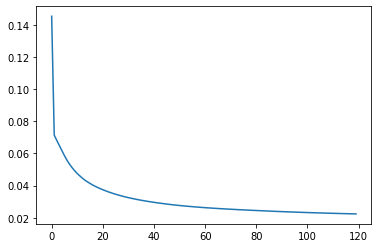

In [14]:
plt.plot(range(len(losslist)),losslist)

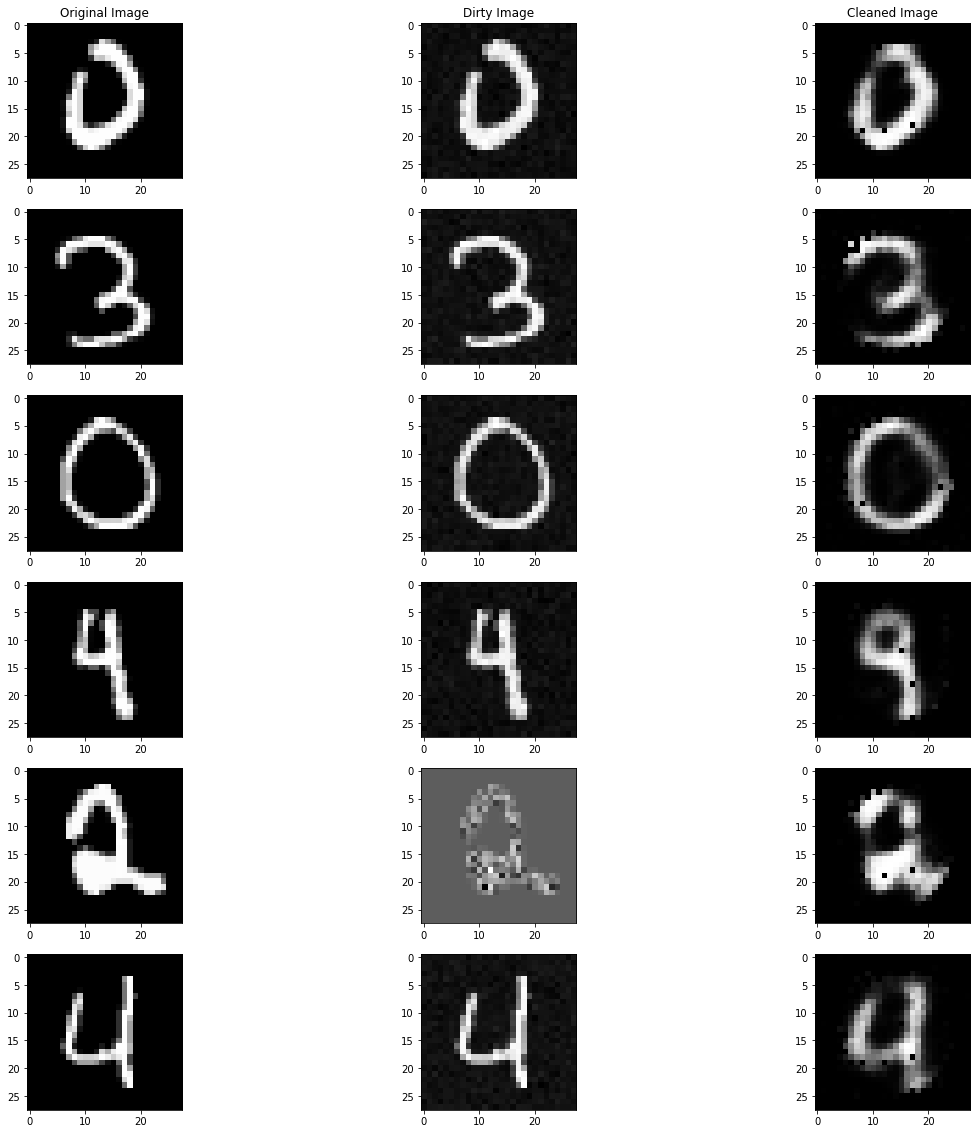

In [15]:
"""Here, we try to visualize some of the results.
  We randomly generate 6 numbers in between 1 and 10k , run them through the model,
  and show the results with comparisons
 """
f,axes= plt.subplots(6,3,figsize=(20,20))
axes[0,0].set_title("Original Image")
axes[0,1].set_title("Dirty Image")
axes[0,2].set_title("Cleaned Image")

test_imgs=np.random.randint(0,10000,size=6)
for idx in range((6)):
  dirty=testset[test_imgs[idx]][0]
  clean=testset[test_imgs[idx]][1]
  label=testset[test_imgs[idx]][2]
  dirty=dirty.view(dirty.size(0),-1).type(torch.FloatTensor)
  dirty=dirty.to(device)
  output=model(dirty)
  
  output=output.view(1,28,28)
  output=output.permute(1,2,0).squeeze(2)
  output=output.detach().cpu().numpy()
  
  dirty=dirty.view(1,28,28)
  dirty=dirty.permute(1,2,0).squeeze(2)
  dirty=dirty.detach().cpu().numpy()
  
  clean=clean.permute(1,2,0).squeeze(2)
  clean=clean.detach().cpu().numpy()
  
  axes[idx,0].imshow(clean,cmap="gray")
  axes[idx,1].imshow(dirty,cmap="gray")
  axes[idx,2].imshow(output,cmap="gray")

In [17]:
PATH = "model"
torch.save(model.state_dict(), PATH)  # We save the model state dict at PATH   